In [1]:
import astropy.units as u
from astropy.time import Time, TimeDelta
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import sunpy.coordinates.sun as sn
import sunpy.map as smap
import tables
###############
import HI_analysis as hip
import HUXt as H
import HIEnsembleHindcast as eh

In [2]:
# Set up the initial details of this case study
###############################################

# Details of the parameters used by SWPC and the resulting forecast and observed arrival time.
kms = u.km/u.s
swpc_cme = {'t_obs':Time('2012-09-28T00:48:00'), 'r_obs':7.5*u.solRad, 'width':110*u.deg, 'lon':20*u.deg, 'lat':4*u.deg,
            'v':872*kms, 't_arr_pred':Time('2012-09-30T15:00:00'), 't_arr_obs':Time('2012-09-30T22:13:00')}

# The label of this event in the Solar Stormwatch data
ssw_event = "ssw_008"

# Get the carrington rotation number, and Earth's coordinates, at SWPCs initial observation time.
cr_num = np.fix(sn.carrington_rotation_number(swpc_cme['t_obs']))
ert = H.Observer('EARTH', swpc_cme['t_obs'])

In [3]:
# Set up HUXt, and produce the deterministic run with SWPCs Cone CME paramters
##############################################################################

model = H.HUXt(cr_num=cr_num, cr_lon_init=ert.lon_c, simtime=4.0*u.day, dt_scale=4.0)

# Workout time of CME at inner boundary, assuming fixed speed.
r_ib = model.r.min()
dt = ((r_ib - swpc_cme['r_obs']) / swpc_cme['v']).to('s')
thickness = 5 * u.solRad
# Setup a ConeCME with these parameters
conecme = H.ConeCME(t_launch=dt, longitude=swpc_cme['lon'], width=swpc_cme['width'], v=swpc_cme['v'], thickness=thickness)

# Run HUXt with this ConeCME
tag = "{}_{}".format(ssw_event, 'deterministic')
model.solve([conecme], save=True, tag=tag)

In [4]:
# Now produce ensemble of HUXt runs with perturbed ConeCME parameters
#####################################################################
np.random.seed(1987)
n_ensemble = 100

lon_spread = 20 * u.deg
width_spread = 20 * u.deg
v_spread = 200 * model.kms
thickness_spread = 2 * u.solRad

for i in range(n_ensemble):
    
    lon = swpc_cme['lon'] + np.random.uniform(-1,1,1)[0] * lon_spread
    width = swpc_cme['width'] + np.random.uniform(-1,1,1)[0] * width_spread
    v = swpc_cme['v'] + np.random.uniform(-1,1,1)[0] * v_spread
    thickness = 5.0*u.solRad + np.random.uniform(-1, 1, 1)[0] * thickness_spread
    
    # Workout time of CME at inner boundary, assuming fixed speed.
    r_ib = model.r.min()
    dt = ((r_ib - swpc_cme['r_obs']) / v).to('s')
    
    # Setup the ConeCME and run the model.
    conecme = H.ConeCME(t_launch=dt, longitude=lon, width=width, v=v, thickness=thickness)
    tag = "{}_ensemble_{:02d}".format(ssw_event, i)
    model.solve([conecme], save=True, tag=tag)

In [5]:
# For each ensemble member, compute the time elongation profile of the CME flank, and save to file.
# This takes ~60 min for 100 ensemble members, due to some inefficient coordinate transforms.
###################################################################################################

project_dirs = H._setup_dirs_()
path = os.path.join(project_dirs['HUXt_data'], "HUXt_CR2128_*_ensemble_*.hdf5")
ensemble_files = glob.glob(path)
n_ens = len(ensemble_files)

# Produce a dictionary of keys of column headings for the dataframes 
# storing the ensemble of time elonation profiles
keys = []
parameters = ['el', 'pa', 'r', 'lon']
for param in parameters:
    for i in range(n_ens):
        keys.append("{}_{:02d}".format(param, i))
    
keys = {k:0 for k in keys}

# Loop over the ensemble files, pull out the elongation profiles and compute arrival time.
for i, file in enumerate(ensemble_files):
    
    model, cme_list = H.load_HUXt_run(file)
    cme = cme_list[0] 

    # Compute the time-elongation profiles of the CME flanks from STA and STB,
    # and store into dataframes for each set of ensembles
    hxta, hxtb = eh.huxt_t_e_profile(model)
    if i == 0:    
        # Make pandas array to store all ensemble t_e_profiles.
        keys['time'] = hxta['time']
        ensemble_sta = pd.DataFrame(keys)
        ensemble_stb = pd.DataFrame(keys)
    
    # Update the ensemble dataframes
    for key in ['r', 'lon', 'el', 'pa']:
        e_key = "{}_{:02d}".format(key, i)
        ensemble_sta[e_key] = hxta[key]
        ensemble_stb[e_key] = hxtb[key]

out_path = project_dirs['out_data']
ensemble_sta.to_csv(os.path.join(out_path, 'ensemble_sta.csv'))
ensemble_stb.to_csv(os.path.join(out_path, 'ensemble_stb.csv'))

In [6]:
# Compute the Solar Stormwatch time-elongation profile along the position angle corresponding to the model
##########################################################################################################

# Compute ensemble average of average PA of the HUXt profiles in the HI FOV.
# PA variability and trend is small enough to assume constant.
sta_pa_avg = 0.0
stb_pa_avg = 0.0
el_keys = ["el_{:02d}".format(i) for i in range(n_ens)]
pa_keys = ["pa_{:02d}".format(i) for i in range(n_ens)]

for i, (ek, pk) in enumerate(zip(el_keys, pa_keys)):
    id_hi = ensemble_sta[ek] <= 25.0   
    sta_pa_avg += ensemble_sta.loc[id_hi, pk].mean() / n_ens
    
    id_hi = ensemble_stb[ek] <= 25.0   
    stb_pa_avg += ensemble_stb.loc[id_hi, pk].mean() / n_ens
    
ssw_sta = eh.get_ssw_profile(ssw_event, 'sta', 'diff', sta_pa_avg, pa_wid=2.0)
ssw_stb = eh.get_ssw_profile(ssw_event, 'stb', 'diff', stb_pa_avg, pa_wid=2.0)
out_path = project_dirs['out_data']
ssw_sta.to_csv(os.path.join(out_path, 'ssw_sta.csv'))
ssw_stb.to_csv(os.path.join(out_path, 'ssw_stb.csv'))

In [7]:
# Compute the CME arrival at Earth for each ensemble member.
############################################################

# List the ensemle files, and set up space for results of comparisons
project_dirs = H._setup_dirs_()
path = os.path.join(project_dirs['HUXt_data'], "HUXt_CR2128_*_ensemble_*.hdf5")
ensemble_files = glob.glob(path)
n_ens = len(ensemble_files)
metrics = pd.DataFrame({'arrival_time':np.zeros(n_ens), 'transit_time':np.zeros(n_ens), 'rmse_a':np.zeros(n_ens), 'rmse_b':np.zeros(n_ens)})

# Loop over the ensemble files, pull out the elongation profiles and compute arrival time.
for i, file in enumerate(ensemble_files):
    
    model, cme_list = H.load_HUXt_run(file)
    cme = cme_list[0] 
    
    # Compute the arrival time for this event
    times =  model.time_init + model.time_out
    ert = H.Observer('EARTH', times)
    # Look up arrival at Earths mean radius over this event - good approx to within ~0.05%
    arr_lon = 0.0*u.rad
    arr_rad = np.mean(ert.r)
    t_arrival, t_transit = eh.compute_arrival_time(model, cme, arr_lon, arr_rad)
    metrics.loc[i, 'arrival_time'] = t_arrival.datetime
    metrics.loc[i, 'transit_time'] = t_transit.value
    
# Make arrival time a datetime, as currently object
metrics['arrival_time'] = pd.to_datetime(metrics['arrival_time'])

# Now use the SSW profiles to compute the rms difference with each huxt ensemble, and update ensemble_metrics.
for i, ek in enumerate(el_keys):
    
    hxt_sta = pd.DataFrame({'time': ensemble_sta['time'], 'el':ensemble_sta[ek]})
    rms, n_rms_samp = eh.compute_rmse(hxt_sta, ssw_sta)
    metrics.loc[i, 'rmse_a'] = rms
    
    hxt_stb = pd.DataFrame({'time': ensemble_stb['time'], 'el':ensemble_stb[ek]})
    rms, n_rms_samp = eh.compute_rmse(hxt_stb, ssw_stb)
    metrics.loc[i, 'rmse_b'] = rms

# Calculate normalised weights. Normalise after computing average weight,
# as otherwise systematic difference between A and B is removed
metrics['w_a'] = 1.0 / metrics['rmse_a']
metrics['w_b'] = 1.0 / metrics['rmse_b']
metrics['w_avg'] = metrics.loc[:, ['w_a', 'w_b']].mean(axis=1)

metrics['w_a'] = metrics['w_a'] / metrics['w_a'].sum()
metrics['w_b'] = metrics['w_b'] / metrics['w_b'].sum()
metrics['w_avg'] = metrics['w_avg'] / metrics['w_avg'].sum()

out_path = project_dirs['out_data']
metrics.to_csv(os.path.join(out_path, 'ensemble_metrics.csv'))


(<Figure size 1944x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x2851ef40630>])

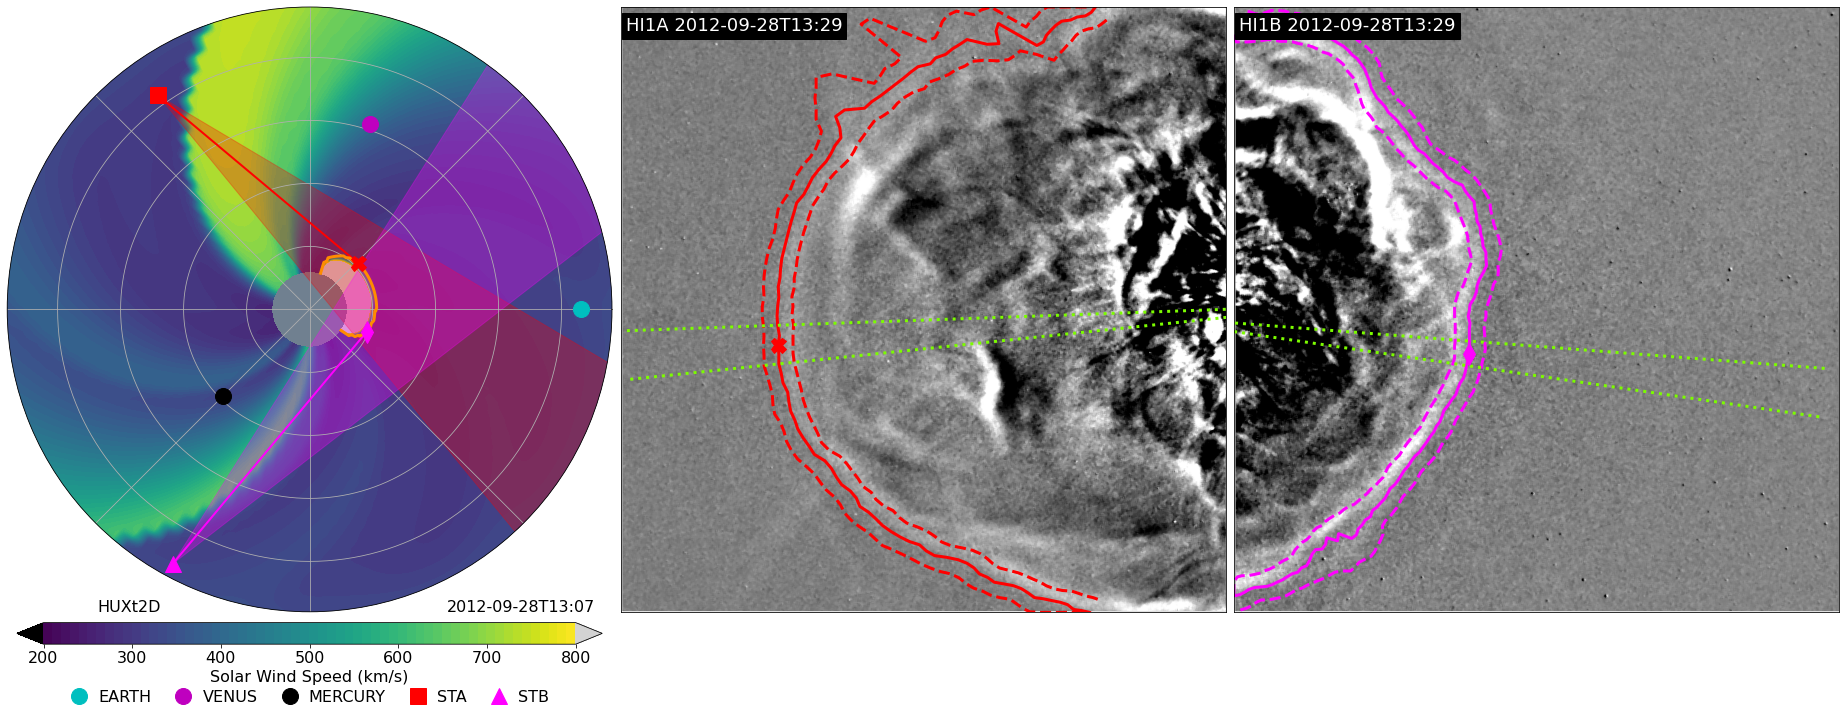

In [3]:
# Make schematic plot of HUXt run with the HI images and SSW classifications
############################################################################

project_dirs = H._setup_dirs_()
path = os.path.join(project_dirs['HUXt_data'],"HUXt_CR2128_ssw_008_deterministic.hdf5")
model, cme_list = H.load_HUXt_run(path)
cme = cme_list[0]

hxt_sta, hxt_stb = eh.huxt_t_e_profile(model)

times =  model.time_init + model.time_out
ert = H.Observer('EARTH', times)
sta = H.Observer('STA', times)
stb = H.Observer('STB', times)

# Load in the HI images
hi1a_path = os.path.join(project_dirs['STEREO_HI_data'],"sta/*.fts")
hi1a_files = glob.glob(hi1a_path)
hi1a_map = hip.get_image_diff(hi1a_files[1], hi1a_files[0], align=True, smoothing=True)

hi1b_path = os.path.join(project_dirs['STEREO_HI_data'],"stb/*.fts")
hi1b_files = glob.glob(hi1b_path)
hi1b_map = hip.get_image_diff(hi1b_files[1], hi1b_files[0], align=True, smoothing=True)

# Load the SSW classifications for the HI images.
ssw_event = 'ssw_008'
img = 'diff'
# Open up the SSW data
ssw_out = tables.open_file(project_dirs['SSW_data'], mode="r")
for craft, hi_map in zip(['sta', 'stb'], [hi1a_map, hi1b_map]):

    # Pull out event
    ssw_path = "/".join(['', ssw_event, craft, img])
    event = ssw_out.get_node(ssw_path)

    key = hi_map.date.strftime('T%Y%m%d_%H%M')+'01'
    cme_slice = event[key]

    # Get the CME front data
    cme = pd.DataFrame.from_records(cme_slice.cme_coords.read())
    cme.replace(to_replace=[99999], value=np.NaN, inplace=True)
    
    if craft == 'sta':
        ssw_sta = cme.copy()
    elif craft == 'stb':
        ssw_stb = cme.copy()
    
ssw_out.close()

t_plot = 0.5 * u.day
eh.plot_huxt_and_hi_schematic(model, t_plot, hi1a_map, hi1b_map, ssw_sta, ssw_stb, sta, stb, hxt_sta, hxt_stb)

In [4]:
project_dirs = H._setup_dirs_()
ensemble_path = os.path.join(project_dirs['HUXt_data'], "HUXt_CR2128_*_ensemble_*.hdf5")
ensemble_files = glob.glob(ensemble_path)
n_ens = len(ensemble_files)

ens_sta = pd.read_csv(os.path.join(project_dirs['out_data'], 'ensemble_sta.csv'))
ens_stb = pd.read_csv(os.path.join(project_dirs['out_data'], 'ensemble_stb.csv'))
metrics = pd.read_csv(os.path.join(project_dirs['out_data'], 'ensemble_metrics.csv'))
ssw_sta = pd.read_csv(os.path.join(project_dirs['out_data'], 'ssw_sta.csv'))
ssw_stb = pd.read_csv(os.path.join(project_dirs['out_data'], 'ssw_stb.csv'))

# Get the deterministic huxt run.
path = os.path.join(project_dirs['HUXt_data'], "HUXt_CR2128_ssw_008_deterministic.hdf5")
model, cme_list = H.load_HUXt_run(path)
cme = cme_list[0]

hxta_det, hxtb_det = eh.huxt_t_e_profile(model)
times =  model.time_init + model.time_out
ert = H.Observer('EARTH', times)
# Look up arrival at Earths mean radius over this event - good approx to within ~0.05%
arr_lon = 0.0*u.rad
arr_rad = np.mean(ert.r)
t_arrive_det, t_transit_det = eh.compute_arrival_time(model, cme, arr_lon, arr_rad)

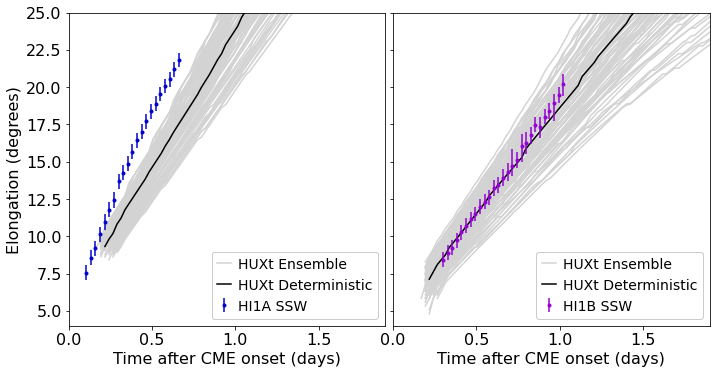

In [5]:
w = 10
h = w / 2.0
fig, ax = plt.subplots(1,2, figsize=(w,h))

el_keys = ["el_{:02d}".format(i) for i in range(n_ens)]

for i, k in enumerate(el_keys):
    ta = ens_sta['time'] - model.time_init.jd
    tb = ens_stb['time'] - model.time_init.jd
    if i == 0:
        ax[0].plot(ta, ens_sta[k], '-', color='lightgrey', zorder=1, label='HUXt Ensemble')
        ax[1].plot(tb, ens_stb[k], '-', color='lightgrey', zorder=1, label='HUXt Ensemble')
    else:
        ax[0].plot(ta, ens_sta[k], '-', color='lightgrey', zorder=1)
        ax[1].plot(tb, ens_stb[k], '-', color='lightgrey', zorder=1)
    
ta = hxta_det['time'] - model.time_init.jd
ax[0].plot(ta, hxta_det['el'], '-', color='k', zorder=1, label='HUXt Deterministic')

tb = hxtb_det['time'] - model.time_init.jd
ax[1].plot(tb, hxtb_det['el'], '-', color='k', zorder=1, label='HUXt Deterministic')


t = ssw_sta['time'] - model.time_init.jd
ax[0].errorbar(t, ssw_sta['el'], yerr=[ssw_sta['el_dlo'], ssw_sta['el_dhi']], fmt='.', color='mediumblue',zorder=2, label='HI1A SSW')

t = ssw_stb['time'] - model.time_init.jd
ax[1].errorbar(t, ssw_stb['el'], yerr=[ssw_stb['el_dlo'], ssw_stb['el_dhi']], fmt='.', color='darkviolet',zorder=2, label='HI1B SSW')
    
for a in ax:
    a.set_xlim(0, 1.9)
    a.set_ylim(4, 25)
    
    a.set_xlabel('Time after CME onset (days)')
    a.legend(loc='lower right', handletextpad=0.5, handlelength=1, columnspacing=0.5, fontsize=14, framealpha=1.0)
    
ax[0].set_ylabel('Elongation (degrees)')
ax[1].set_yticklabels([])

fig.subplots_adjust(left=0.1, bottom=0.11, right=0.99, top=0.98, wspace=0.025)
project_dirs = H._setup_dirs_()
fig_name = os.path.join(project_dirs['figures'], 'figure_2_time_elon_profiles.png')
fig.savefig(fig_name)

In [6]:
metrics['arrival_time'] = pd.to_datetime(metrics['arrival_time'])

# Compute median, and IQR of ens avg, and weighted avergages. 
ms = metrics.sort_values(by='arrival_time', ascending=True)
ms.set_index(np.arange(0,ms.shape[0]), inplace=True)
ms['cwa'] = ms['w_a'].cumsum()
ms['cwb'] = ms['w_b'].cumsum()
ms['cwavg'] = ms['w_avg'].cumsum()

arrival_error = np.abs(ms['arrival_time'] - pd.Timestamp(swpc_cme['t_arr_obs'].datetime))
ms['error'] = arrival_error.dt.total_seconds() / 3600.0

stats = {'obs':{'arrival':0, 'error':np.NaN, 'skill':np.NaN},
        'swpc':{'arrival':0, 'error':0, 'skill':np.NaN},
        'det':{'arrival':0, 'error':0, 'skill':np.NaN},
        'ens':{'arrival':0, 'lo':0, 'hi':0, 'error':0, 'skill':0},
        'cwa':{'arrival':0, 'lo':0, 'hi':0, 'error':0, 'skill':0},
        'cwb':{'arrival':0, 'lo':0, 'hi':0, 'error':0, 'skill':0},
        'cwavg':{'arrival':0, 'lo':0, 'hi':0, 'error':0, 'skill':0}}

q_lo = 0.16
q_hi = 0.84

stats['obs']['arrival'] = pd.Timestamp(swpc_cme['t_arr_obs'].datetime)
stats['swpc']['arrival'] = pd.Timestamp(swpc_cme['t_arr_pred'].datetime)
stats['swpc']['error'] = (stats['swpc']['arrival'] - stats['obs']['arrival']).total_seconds()/3600

stats['det']['arrival'] = pd.Timestamp(t_arrive_det.datetime)
stats['det']['error'] = (stats['det']['arrival'] - stats['obs']['arrival']).total_seconds()/3600
stats['det']['skill'] = 1.0 - np.abs(stats['det']['error'] / stats['swpc']['error'])

for key in ['ens', 'cwa', 'cwb', 'cwavg']:
    
    if key == 'ens':
        stats[key]['arrival'] = ms['arrival_time'].quantile(0.5)
        stats[key]['lo'] = ms['arrival_time'].quantile(q_lo)
        stats[key]['hi'] = ms['arrival_time'].quantile(q_hi)
    else:
        id_med = np.searchsorted(ms[key], 0.5)
        stats[key]['arrival'] = ms.loc[id_med, 'arrival_time']
        
        id_lo = np.searchsorted(ms[key], q_lo)
        stats[key]['lo'] = ms.loc[id_lo, 'arrival_time']
        
        id_hi = np.searchsorted(ms[key], q_hi)
        stats[key]['hi'] = ms.loc[id_hi, 'arrival_time']
        
    stats[key]['error'] = (stats[key]['arrival'] - stats['obs']['arrival']).total_seconds()/3600
    stats[key]['skill'] = 1.0 - np.abs(stats[key]['error'] / stats['swpc']['error'])
    
fmt = "%Y-%m-%dT%H:%M"
for key, val in stats.items():
    
    if key in ['ens', 'cwa', 'cwb', 'cwavg']:
        date = val['arrival'].strftime(fmt)
        lo = (val['arrival'] - val['lo']).total_seconds()/3600
        hi = (val['hi'] - val['arrival']).total_seconds()/3600
        err = val['error']
        print(key + " {} & \\pm^{{{:3.1f}}}_{{{:3.1f}}}$ & {:3.1f} & {:3.2f}\\\\".format(date, hi, lo, err, val['skill']))
    else:
        print(key + "  {} & {:3.1f} & {:3.2f}\\\\".format(val['arrival'].strftime(fmt), val['error'], val['skill']))
    

obs  2012-09-30T22:13 & nan & nan\\
swpc  2012-09-30T15:00 & -7.2 & nan\\
det  2012-10-01T00:17 & 2.1 & 0.71\\
ens 2012-10-01T01:01 & \pm^{6.0}_{4.5}$ & 2.8 & 0.61\\
cwa 2012-10-01T00:17 & \pm^{4.3}_{4.5}$ & 2.1 & 0.71\\
cwb 2012-10-01T00:35 & \pm^{3.6}_{4.1}$ & 2.4 & 0.67\\
cwavg 2012-10-01T00:17 & \pm^{3.9}_{4.1}$ & 2.1 & 0.71\\


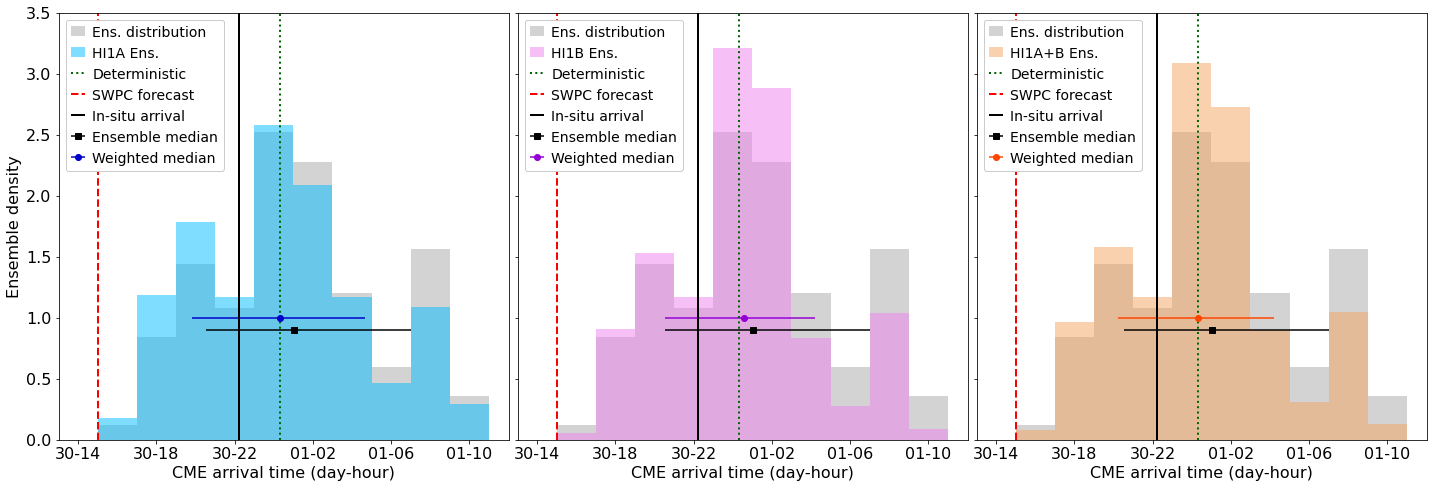

In [7]:
w = 20
h = w / 3.0
fig, ax = plt.subplots(1, 3, figsize=(w,h))

t_lo = metrics['arrival_time'].min() - pd.Timedelta("2H")
t_hi = metrics['arrival_time'].max() + pd.Timedelta("2H")
bins = pd.date_range(t_lo.round('H'), t_hi.round('H'), freq="2H")

t_arr_swpc = swpc_cme['t_arr_pred'].datetime
t_arr_obs = swpc_cme['t_arr_obs'].datetime

hist_colors = {'w_a':'deepskyblue', 'w_b':'violet', 'w_avg':'sandybrown'}
line_colors = {'w_a':'mediumblue', 'w_b':'darkviolet', 'w_avg':'orangered'}
labels = {'w_a':'HI1A', 'w_b':'HI1B', 'w_avg':'HI1A+B'}
for a, key, color in zip(ax, ['w_a', 'w_b', 'w_avg'], ['blue', 'green', 'orange']):
    a.hist(metrics['arrival_time'], bins, density=True, color='lightgrey', label='Ens. distribution')
    
    a.hist(metrics['arrival_time'], bins, weights=metrics[key], density=True, color=hist_colors[key], alpha=0.5,
           label=labels[key] + ' Ens.')
        
    dxl = stats['ens']['arrival'] - stats['ens']['lo']
    dxu = stats['ens']['hi'] - stats['ens']['arrival']
    a.errorbar(stats['ens']['arrival'], 0.9, xerr=[[dxl], [dxu]], fmt='ks', label='Ensemble median')
    
    if key == 'w_a':
        key2 = 'cwa'
    elif key == 'w_b':
        key2 = 'cwb'
    elif key == 'w_avg':
        key2 = 'cwavg'
        
    dxl = stats[key2]['arrival'] - stats[key2]['lo']
    dxu = stats[key2]['hi'] - stats[key2]['arrival']
    a.errorbar(stats[key2]['arrival'], 1.0, xerr=[[dxl], [dxu]], fmt='o', color=line_colors[key], label='Weighted median')
        
    a.vlines(t_arrive_det.datetime, 0, 3.5, colors='darkgreen', linewidths=2, linestyles=':', label='Deterministic')
    
    a.vlines(t_arr_swpc, 0, 3.5, colors='r', linewidths=2, linestyles='--', label='SWPC forecast')
    
    a.vlines(t_arr_obs, 0, 3.5, colors='k', linewidths=2, label='In-situ arrival')
    
    a.set_xlim('2012-09-30T13:00', '2012-10-01T12:00')
    a.set_ylim(0, 3.5)
    a.set_xlabel('CME arrival time (day-hour)')
    
    hours = mpl.dates.HourLocator(interval=4)   # every hour
    hours_fmt = mpl.dates.DateFormatter('%d-%H')

    # format the ticks
    a.xaxis.set_major_locator(hours)
    a.xaxis.set_major_formatter(hours_fmt)

for a in ax[1:]:
    a.set_yticklabels([])
    
for a in ax:
    a.legend(loc='upper left', ncol=1, handletextpad=0.5, handlelength=1, columnspacing=0.5, fontsize=14, framealpha=1.0)
    
ax[0].set_ylabel('Ensemble density')
 
fig.subplots_adjust(left=0.04,bottom=0.09,right=0.99,top=0.98,wspace=0.02)
project_dirs = H._setup_dirs_()
fig_name = os.path.join(project_dirs['figures'], 'figure_3_arrival_distribution.png')
fig.savefig(fig_name)

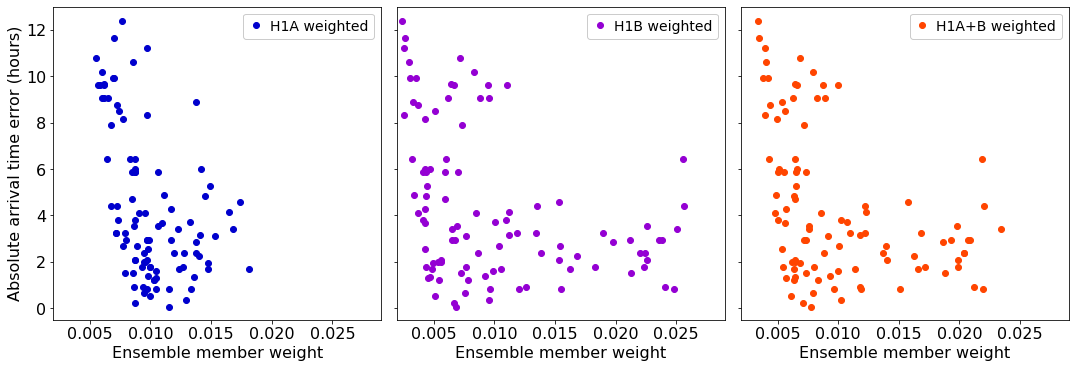

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(ms['w_a'], np.abs(ms['error']) ,'o', color='mediumblue', label='H1A weighted')
ax[1].plot(ms['w_b'], np.abs(ms['error']) ,'o', color='darkviolet', label='H1B weighted')
ax[2].plot(ms['w_avg'], np.abs(ms['error']) ,'o', color='orangered', label='H1A+B weighted')

ax[0].set_ylabel('Absolute arrival time error (hours)')
for a in ax:
    a.set_xlabel('Ensemble member weight')
    a.set_xlim(0.002, 0.029)
    a.set_ylim(-0.5, 13)
    a.legend(loc='upper right', handletextpad=0.5, handlelength=1, fontsize=14, framealpha=1.0)

for a in ax[1:]:
    a.set_yticklabels([])
    
fig.subplots_adjust(left=0.05,bottom=0.12,right=0.99,top=0.99,wspace=0.05)
project_dirs = H._setup_dirs_()
fig_name = os.path.join(project_dirs['figures'], 'figure_4_error_vs_weight.png')
fig.savefig(fig_name)